<a href="https://colab.research.google.com/github/KARENCMP82/Python/blob/main/Clase_3_Cat_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este notebook construiremos un algoritmo de reconocimiento de imagenes.
Entrenaremos nuestro algoritmo sobre un dataset de imagenes de gatos etiquetadas, y lo testearemos para evaluar su performance.

Paso a paso, veremos cómo:

- Solucionar un problema de logistic regression, mediante técnicas de redes neuronales.

- Aprender a minimizar la cost function.

- Entender cómo se utilizan las derivadas de la cost function para actualizar los parámetros.



Aquí tenemos la arquitectura de nuestro problema de clasificación:

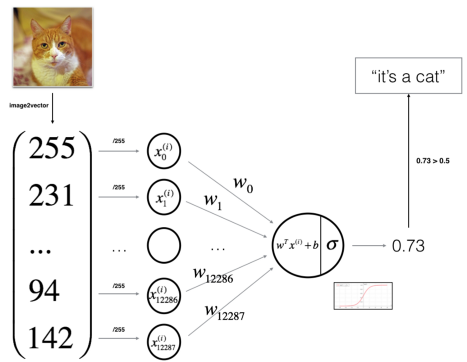


Primero importamos todos los paquetes necesarios:
- numpy es el paquete fundamental para la computación científica con Python.
- h5py es un paquete común para interactuar con un conjunto de datos que se almacena en un archivo H5.
- matplotlib es una biblioteca famosa para trazar gráficos en Python.
- PIL y scipy se usan aquí para probar nuestro modelo con una nueva imagen al final.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
# Importar las bibliotecas necesarias
import h5py  # Biblioteca para interactuar con archivos HDF5 (formato común para guardar grandes datasets)
import numpy as np # Biblioteca para operaciones numéricas, especialmente con arrays
from google.colab import drive  # Biblioteca para montar Google Drive
import os # Importar el módulo os para trabajar con rutas de archivos

# Montar Google Drive
drive.mount('/content/drive')

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Nos bajamos el dataset de Kaggle:

https://www.kaggle.com/innalytvynenko/classwork4-deep-learning-lab4-cat-classification-2

In [29]:
# Definir la ruta base en Google Drive
ruta_base_drive = "/content/drive/MyDrive/Colab Notebooks/Ejercicios"

# Construir las rutas completas para los archivos de entrenamiento y prueba
train_file_path = os.path.join(ruta_base_drive, 'train_catvnoncat.h5')
test_file_path = os.path.join(ruta_base_drive, 'test_catvnoncat.h5')

# Imprimir las rutas para verificar (opcional)
print(f"Ruta archivo entrenamiento: {train_file_path}")
print(f"Ruta archivo prueba: {test_file_path}")

Ruta archivo entrenamiento: /content/drive/MyDrive/Colab Notebooks/Ejercicios/train_catvnoncat.h5
Ruta archivo prueba: /content/drive/MyDrive/Colab Notebooks/Ejercicios/test_catvnoncat.h5


In [27]:
def load_dataset_from_drive():  #: Cambiado el nombre para claridad (opcional)
    # Abrir el archivo de entrenamiento desde la ruta de Drive
    train_dataset = h5py.File(train_file_path, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    # Abrir el archivo de prueba desde la ruta de Drive
    test_dataset = h5py.File(test_file_path, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    # Cerrar los archivos (buena práctica)
    train_dataset.close()
    test_dataset.close()

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig,

El dataset contiene:
- un train set de imágenes etiquetadas como gato (y=1) o no gato (y=0)
- un test set de imágenes etiquetadas como gato o no gato
- cada imagen tiene dimensiones (num_px, num_px, 3) donde 3 es para (RGB)


In [28]:
#  Llamar a la función correcta
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset_from_drive()

ValueError: not enough values to unpack (expected 5, got 4)

Hemos puesto "_orig" al final de los datasets de imágenes (train y test) porque los vamos a preprocesar.

Después del procesamiento, tendremos con train_set_x y test_set_x (las etiquetas train_set_y y test_set_y no necesitan ningún procesamiento previo).

Cada línea del train_set_x_orig y test_set_x_orig es una matriz que representa una imagen.

Podemos visualizar un ejemplo ejecutando el siguiente código:

y = [1], it's a 'cat' picture.


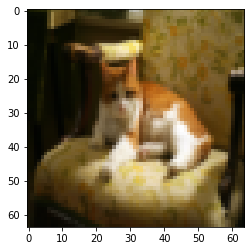

In [ ]:
# Example of a picture
index = 7
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [ ]:
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Queremos encontrar los valores para:

- m_train (número de ejemplos de entrenamiento)
- m_test (número de ejemplos de prueba)
- num_px (= alto = ancho de una imagen de entrenamiento)

In [ ]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
--num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")

SyntaxError: ignored

## Preprocesamiento

Ahora pasaremos el formato de las imágenes de matriz a vector.

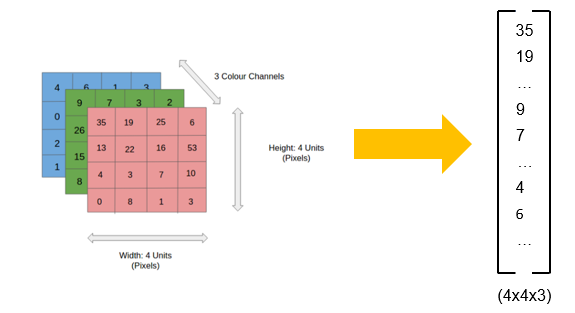

Un truco para aplanar una matriz X de forma (a,b,c,d) a una matriz X_flatten de forma (b*c*d, a) es usar:
```
X_flatten = X.reshape(X.shape[0], -1).T   
```

In [ ]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


Ahora estandarizamos nuestros datasets dividiendo por 255, que es el máximo valor de RGB.

In [ ]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

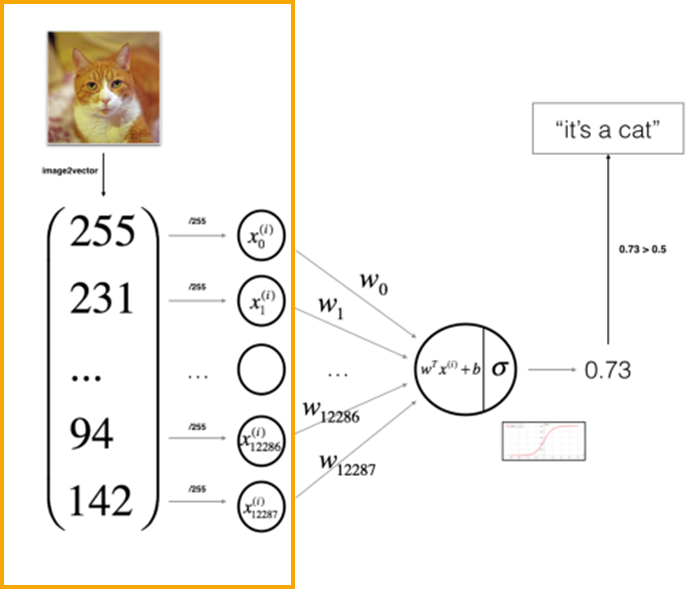

Recuerda: los pasos que corresponden al preprocesamiento son los siguientes
- Calcular las dimensiones (m_train, m_test, num_px, ...)
- Modificar el dataset de modo que cada ejemplo sea ahora un vector de tamaño (num_px * num_px * 3, 1)
- Estandarizar los datos

## Construir la red neuronal

Los pasos principales para construir una red neuronal son:

1. Definir la estructura del modelo (como por ejemplo el número de features de entrada)
2. Inicializar los parámetros del modelo.
3. Loop:
  - Calcular la loss function (forward propagation)
  - Calcular el gradiente (backward propagation)
  - Actualizar los parámetros (gradient descent)


Empezamos definiendo la sigmoid function.

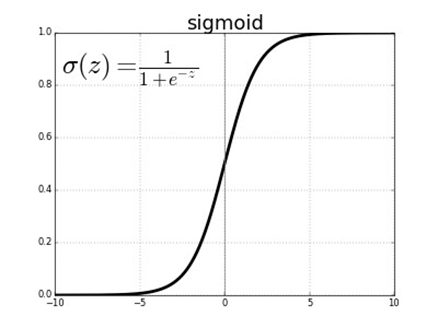

In [ ]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

Ahora inicializamos los parámetros, en función de la dimensión deseada.

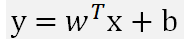

Se inicializan a 0:

In [ ]:
def initialize_param(dim):
    w = np.zeros((dim,1))
    b = 0
    return w, b

## Propagation

Ahora que los parámetros están definidos, podemos empezar con la forward y backward propagation.

La forward propagation corresponde a propagar el input:

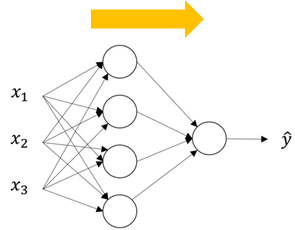

Cada nodo recibe un input, realiza el cálculo y aplica una función de activación:

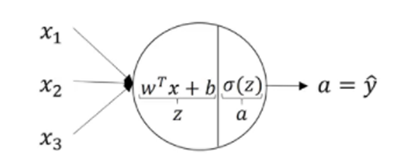

```
Z = np.dot(w.T,X)+b
A = sigmoid(Z)
```

Al final de la forward propagation, calculamos la cost function:

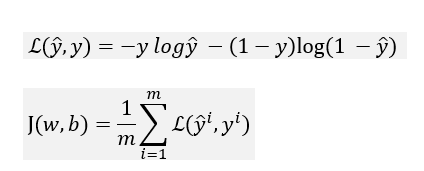

```
cost = (-1/m)*np.sum((Y*np.log(A))+(1-Y)*np.log(1-A))
```

Con la backward propagation, volvemos hacía la izquierda propagando el error:

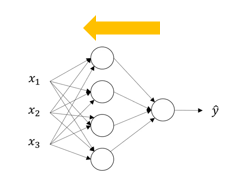

La backward propagation corresponde a calcular los gradientes (derivadas) de la cost función, con respecto a los parámetros actuales.

Las formulas de las derivadas son las siguientes:

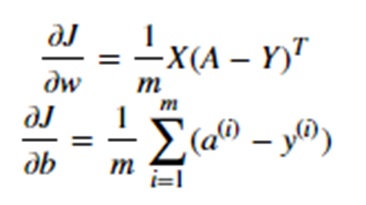

```
dw = (1/m)*np.dot(X,(A-Y).T)
db = (1/m)*np.sum(A-Y)
```

Ahora podemos juntar todos estos cálculos, que corresponden a una iteración:

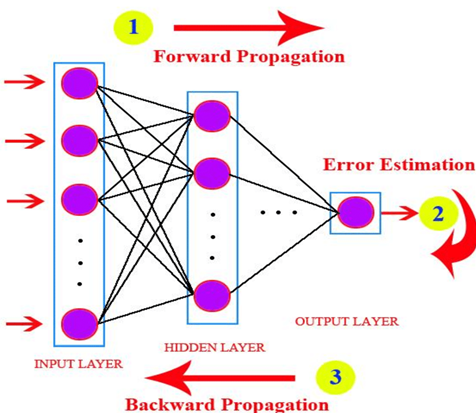

In [ ]:
def propagate(w, b, X, Y):

    # m corresponde al número de training examples
    m = X.shape[1]

    # 1. FORWARD PROPAGATION
    A = sigmoid(np.dot(w.T,X)+b)

    # 2. COST FUNCTION
    cost = (-1/m)*np.sum((Y*np.log(A))+(1-Y)*np.log(1-A))

    # 3. BACKWARD PROPAGATION
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)

    # los outputs que queremos son:
    # - cost function (para ver si la estamos minimizando)
    # - gradientes (para actualizar los parámetros)

    # numpy.squeeze() function is used when we want to remove
    # single-dimensional entries from the shape of an array.
    cost = np.squeeze(cost)
    grads = {"dw": dw,
             "db": db}

    return grads, cost

## Optimización

Ahora que hemos juntado el código que corresponde a una iteración, vemos cómo seguir iterando para optimizar los parámetros según la técnica del gradient descent.

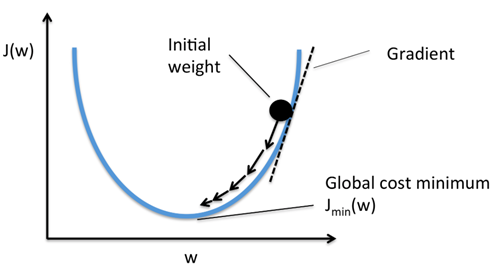

Para un parámetro θ, la regla de actualización es:

θ=θ−α*dθ

donde α es la tasa de aprendizaje.

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost):

    # lista que contendrá el valor de la cost function para cada iteración
    costs = []

    for i in range(num_iterations):


        # Forward propagation, cost function y backward propagation.
        # Devuelve los gradientes para actualizar los parámetros,
        # y el valor de la cost function para esa iteración
        grads, cost = propagate(w, b, X, Y)

        # Asignamos los correspondientes valores de los gradientes
        # (recordemos que "grads" es un diccionario)
        dw = grads["dw"]
        db = grads["db"]

        # Actualizamos los parámetros
        w = w - learning_rate*dw
        b = b - learning_rate*db

        # Registramos el coste de esta iteración
        if i % 100 == 0:
            costs.append(cost)

        # Imprimimos el coste cada 100 iteraciones
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

La función que acabamos de definir nos devuelve nuestros parametros "w" y "b" optimizados, después de un número de iteraciones.

Ahora podemos usar los parámetros aprendidos para predecir las etiquetas de un dataset X.

Tenemos que crear la función predict().
Hay dos pasos para calcular las predicciones:
- Calcular Ŷ=A=σ(w(transpose)X+b) con los parámetros aprendidos
- Convertir los valores "de" a en 0 (si activación <= 0.5) o 1 (si activación > 0.5), y guardar las predicciones en un vector Y_prediction

In [ ]:
def predict(w, b, X):

    # número de ejemplos en el dataset
    m = X.shape[1]

    # inicializar el vector de predicciones
    Y_prediction = np.zeros((1,m))

    # reshape los parámetros para que sea un vector
    w = w.reshape(X.shape[0], 1)

    # calculamos el vector "A", prediciendo las probabilidades que la foto sea de un gato
    A = sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):

        # cambiamos las probabilities A[0,i] a predicciones p[0,i] de tipo 0/1
        if A[0,i] <= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

Hemos definido distintas funciones para realizar todos los pasos del modelo:
1. Inicializar los parámetros (w,b)
2. Optimizar la cost function de forma iterativa para aprender los parámetros (w, b):
  - calculando la cost function y su gradiente
  - actualizando los parámetros usando gradient descent
3. Usar los parámetros aprendidos (w,b) para predecir las etiquetas para un dataset de ejemplos

## Crear el modelo

Ahora simplemente tendremos que juntar todos estos bloques (las funciones implementadas en las partes anteriores), en el orden correcto.

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost):

    # 1. inicializamos los parámetros. La dimensión corresponde a (num_px*num_px*3)
    w, b = initialize_param(train_set_x_orig.shape[1]*train_set_x_orig.shape[1]*3)

    # 2. optimizamos con el Gradient descent
    param_dict, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # asignamos a los parámetros el valor que cada uno tiene en el diccionario "param_dict"
    w = param_dict["w"]
    b = param_dict["b"]

    # 3. utilizamos los parámetros aprendidos para predecir las etiquetas en un dataset de ejemplo (test/train)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # imprimimos los errores en train/test
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

Entrenamos el modelo:

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


La train accuracy es cercana al 100%. Esto funciona cómo verificación de que el modelo está funcionando y tiene la capacidad suficiente para adaptarse a los datos de entrenamiento.

La test accuracy es del 70%. En realidad, no está mal para este modelo sencillo, dado el pequeño conjunto de datos que usamos y que la regresión logística es un clasificador lineal.

y = 0, you predicted that it is a "non-cat" picture.


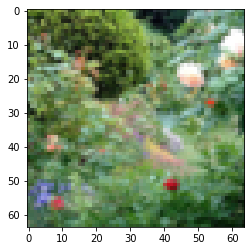

In [ ]:
index = 49
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

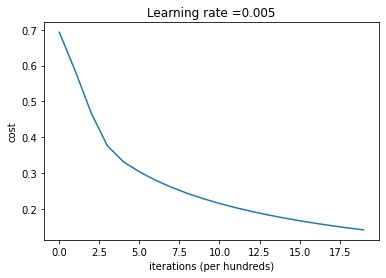

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()